Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Obtain Data 

In [ ]:
dfGames = pd.read_csv('/content/COMBINEDgamesWithInfo2016-19.csv')

In [ ]:
dfGames = dfGames.drop(['Unnamed: 0'], axis=1)
dfGames.columns

Index(['Home', 'Away', 'W_PCT', 'REB', 'TOV', 'PLUS_MINUS', 'OFF_RATING',
       'DEF_RATING', 'TS_PCT', 'Result', 'Date'],
      dtype='object')

In [ ]:
dfGames.head()

,Home,Away,W_PCT,REB,TOV,PLUS_MINUS,OFF_RATING,DEF_RATING,TS_PCT,Result,Date
0,Philadelphia 76ers,Chicago Bulls,-1.764924,-3.739935,2.574073,-2.619013,-2.549887,0.993680,-0.201678,0,11/25/2016
1,Los Angeles Lakers,Golden State Warriors,-1.945127,-0.311661,0.980599,-2.601317,-1.762117,1.925254,-1.734430,0,11/25/2016
2,New York Knicks,Charlotte Hornets,-0.376305,0.000000,1.838624,-1.044066,-0.497539,1.179995,-0.322685,1,11/25/2016
3,Phoenix Suns,Minnesota Timberwolves,0.143102,-0.089046,-0.183862,-0.884802,-1.036539,0.186315,-0.726040,0,11/25/2016
4,Boston Celtics,San Antonio Spurs,-1.060015,0.000000,0.429012,-0.814018,-0.704847,0.372630,-0.645369,0,11/25/2016


Split Data

In [ ]:
train, test = train_test_split(dfGames, test_size = 0.25, random_state = 10)

xtrain = train[['W_PCT', 'REB', 'TOV', 'PLUS_MINUS', 'OFF_RATING', 'DEF_RATING', 'TS_PCT']]
ytrain = train[['Result']]

xtest = test[['W_PCT', 'REB', 'TOV', 'PLUS_MINUS', 'OFF_RATING', 'DEF_RATING', 'TS_PCT']]
ytest = test[['Result']]

df_predictions = test.drop(labels=['W_PCT', 'REB', 'TOV', 'PLUS_MINUS', 'OFF_RATING', 'DEF_RATING', 'TS_PCT'], axis=1)

Tune Hyperparameters

The following code references http://www.davidsbatista.net/blog/2018/02/23/model_optimization/

In [ ]:
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def f1(self, sort_by='mean_f1', name = 'f1', k=None):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'mean_f1': np.mean(scores),
            }
            return pd.Series({**d, **params})

        rows = []
        params = self.grid_searches[k].cv_results_['params']
        scores = []
        for i in range(self.grid_searches[k].cv):
            key = "split{}_test_f1".format(i)
            r = self.grid_searches[k].cv_results_[key]        
            scores.append(r.reshape(len(params),1))

        all_scores = np.hstack(scores)
        for p, s in zip(params,all_scores):
            rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'mean_f1']
        columns = ['estimator'] + [c for c in df.columns if c not in columns] + ['mean_f1'] 
        # print("F1", df[columns])

        return df[columns]

    def accuracy(self, sort_by='mean_accuracy', name = 'accuracy', k=None):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'mean_accuracy': np.mean(scores),
            }
            return pd.Series({**d, **params})

        rows = []
        params = self.grid_searches[k].cv_results_['params']
        scores = []
        for i in range(self.grid_searches[k].cv):
            key = "split{}_test_accuracy".format(i)
            r = self.grid_searches[k].cv_results_[key]        
            scores.append(r.reshape(len(params),1))

        all_scores = np.hstack(scores)
        for p, s in zip(params,all_scores):
            rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'mean_accuracy']
        columns = ['estimator'] + [c for c in df.columns if c not in columns] + ['mean_accuracy'] 
        # print("Accuracy", df[columns])

        return df[columns]

    def recall(self, sort_by='mean_recall', name = 'recall', k=None):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'mean_recall': np.mean(scores),
            }
            return pd.Series({**d, **params})

        rows = []
        params = self.grid_searches[k].cv_results_['params']
        scores = []
        for i in range(self.grid_searches[k].cv):
            key = "split{}_test_recall".format(i)
            r = self.grid_searches[k].cv_results_[key]        
            scores.append(r.reshape(len(params),1))

        all_scores = np.hstack(scores)
        for p, s in zip(params,all_scores):
            rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'mean_recall']
        columns = ['estimator'] + [c for c in df.columns if c not in columns] + ['mean_recall'] 
        # print("Recall", df[columns])
        return df[columns]

    def precision(self, sort_by='mean_precision', name = 'precision', k=None):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'mean_precision': np.mean(scores),
            }
            return pd.Series({**d, **params})

        rows = []
        params = self.grid_searches[k].cv_results_['params']
        scores = []
        for i in range(self.grid_searches[k].cv):
            key = "split{}_test_precision".format(i)
            r = self.grid_searches[k].cv_results_[key]        
            scores.append(r.reshape(len(params),1))

        all_scores = np.hstack(scores)
        for p, s in zip(params,all_scores):
            rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'mean_precision']
        columns = ['estimator'] + [c for c in df.columns if c not in columns] + ['mean_precision'] 
        # print ("precision", df[columns])
        return df[columns]

    def score_summary(self, model_name=None):
        f1 = self.f1(k=model_name)
        accuracy = self.accuracy(k=model_name)
        recall = self.recall(k=model_name)
        precision = self.precision(k=model_name)
        df = pd.merge(accuracy, f1)
        df = pd.merge(df, recall)
        df = pd.merge(df, precision)
        return df

In [ ]:
models1 = {
    'MLPClassifier': MLPClassifier(activation='relu', random_state=18),
    'BaggingClassifier': BaggingClassifier(random_state=18),
    'SVC': SVC(random_state=18)
}

params1 = {
    'MLPClassifier': {'solver': ['adam', 'sgd'], 
                      'learning_rate': ['constant', 'adaptive'], 
                      'alpha': [0.0001, 0.00001, 0.1], 
                      'learning_rate_init': [0.001, 0.0001, .1] },
    'BaggingClassifier': {'n_estimators': [10, 25, 50], 'max_features': [1.0, 2, 4, 6], 'bootstrap': [True, False]},
    'SVC': {'kernel': ['rbf', 'poly'], 'C': [1, 10, 50], 'gamma': ['auto', 0.001, 0.0001]}
}

In [ ]:
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(xtrain, ytrain, scoring=['accuracy', 'f1', 'recall', 'precision'])

Running GridSearchCV for MLPClassifier.
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   31.7s
[Parallel(n_jobs=3)]: Done 108 out of 108 | elapsed:  1.2min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for BaggingClassifier.
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    9.0s
[Parallel(n_jobs=3)]: Done  72 out of  72 | elapsed:   15.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for SVC.
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   22.0s
[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed:   23.2s finished


GridSearchCV Results

In [ ]:
df_svc = helper1.score_summary(model_name='SVC')
df_svc.sort_values(by=['mean_accuracy'],ascending=False)

,estimator,C,gamma,kernel,mean_accuracy,mean_f1,mean_recall,mean_precision
0,SVC,1,auto,rbf,0.642857,0.712676,0.769349,0.664126
1,SVC,1,0.001,rbf,0.641534,0.721428,0.806897,0.652483
2,SVC,50,0.0001,rbf,0.641534,0.716405,0.786973,0.657655
3,SVC,10,0.0001,rbf,0.640653,0.718224,0.796169,0.654281
4,SVC,10,0.001,rbf,0.637125,0.729602,0.851341,0.638518
5,SVC,50,0.001,rbf,0.634039,0.727647,0.849808,0.636253
6,SVC,50,auto,poly,0.617725,0.726731,0.883525,0.617476
7,SVC,10,auto,poly,0.616843,0.730058,0.900383,0.6142
8,SVC,1,auto,poly,0.614638,0.734616,0.927203,0.608593
9,SVC,10,auto,rbf,0.61067,0.67943,0.716475,0.646348


In [ ]:
df_rf = helper1.score_summary(model_name='BaggingClassifier')
df_rf.sort_values(by=['mean_accuracy'],ascending=False)


,estimator,bootstrap,max_features,n_estimators,mean_accuracy,mean_f1,mean_recall,mean_precision
0,BaggingClassifier,True,2,25,0.617284,0.684125,0.720307,0.651416
1,BaggingClassifier,True,2,50,0.611993,0.677954,0.709579,0.649089
2,BaggingClassifier,True,4,50,0.611993,0.67631,0.704215,0.650568
3,BaggingClassifier,True,4,25,0.611552,0.676759,0.706513,0.6496
4,BaggingClassifier,True,1,50,0.606702,0.669071,0.691188,0.648484
5,BaggingClassifier,False,2,50,0.60582,0.669236,0.69272,0.647589
6,BaggingClassifier,False,2,25,0.601411,0.666225,0.691188,0.643065
7,BaggingClassifier,True,1,25,0.599647,0.668626,0.701916,0.638567
8,BaggingClassifier,True,4,10,0.594797,0.636223,0.616092,0.65833
9,BaggingClassifier,True,6,25,0.593915,0.662855,0.694253,0.634494


In [ ]:
df_nn = helper1.score_summary(model_name='MLPClassifier')
df_nn.sort_values(by=['mean_accuracy'],ascending=False)


,estimator,alpha,learning_rate,learning_rate_init,solver,mean_accuracy,mean_f1,mean_recall,mean_precision
0,MLPClassifier,0.0001,constant,0.001,sgd,0.642857,0.71352,0.77318,0.662666
1,MLPClassifier,1e-05,constant,0.001,sgd,0.642857,0.71352,0.77318,0.662666
2,MLPClassifier,0.1,constant,0.001,sgd,0.642857,0.71352,0.77318,0.662666
3,MLPClassifier,0.1,adaptive,0.001,sgd,0.642857,0.713104,0.771648,0.663049
11,MLPClassifier,0.0001,constant,0.0001,adam,0.642416,0.713293,0.77318,0.662245
10,MLPClassifier,0.1,adaptive,0.001,adam,0.642416,0.708745,0.755556,0.66843
9,MLPClassifier,0.0001,adaptive,0.001,sgd,0.642416,0.712853,0.771648,0.662629
8,MLPClassifier,1e-05,adaptive,0.001,sgd,0.642416,0.712853,0.771648,0.662629
7,MLPClassifier,0.1,constant,0.001,adam,0.642416,0.708745,0.755556,0.66843
6,MLPClassifier,1e-05,constant,0.0001,adam,0.642416,0.713293,0.77318,0.662245


Using PCA to plot data and evaluate linear separability

The following code references https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

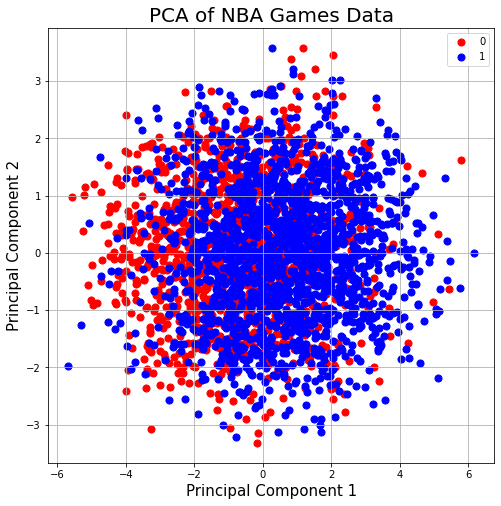

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = ['W_PCT', 'REB', 'TOV', 'PLUS_MINUS', 'OFF_RATING', 'DEF_RATING', 'TS_PCT']

# Separating out the features
x = dfGames.loc[:, features].values

# Separating out the target
y = dfGames.loc[:,['Result']].values

x = StandardScaler().fit_transform(x)

principalComponents = PCA(n_components=2).fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, dfGames[['Result']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA of NBA Games Data', fontsize = 20)
targets = [0, 1]
colors = ['r','b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Result'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()


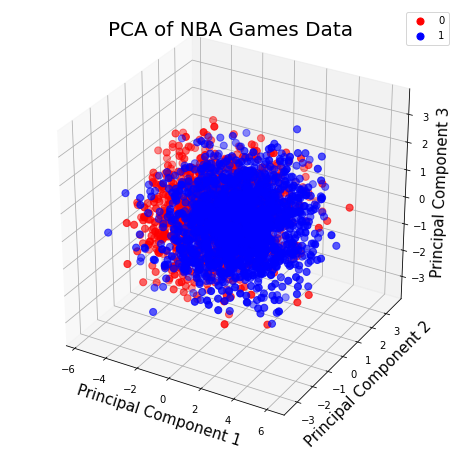

In [ ]:
principalComponents = PCA(n_components=3).fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
finalDf = pd.concat([principalDf, dfGames[['Result']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('PCA of NBA Games Data', fontsize = 20)
targets = [0, 1]
colors = ['r','b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Result'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()


A single perceptron basically finds the decision boundary given samples and labels. It learns a series of weights that are used in a linear combination of the inputs. This value is then processed by the activation function and produces an binary classification. Due to the nature of this classifier, it can only classify linearly separable data (XOR problem). 

http://www.ece.utep.edu/research/webfuzzy/docs/kk-thesis/kk-thesis-html/node19.html




In [ ]:
single = Perceptron(random_state=18)
single.fit(xtrain, ytrain.values.ravel())
single.score(xtrain, ytrain)

0.4704585537918871

SVM's with linear kernel tries to separate the data with a soft margin that maximizes the distance between two sides. Making C large wil allow close to 0 misclassifications. If the model separates the training data close to 100%, then it's linearly separable. 

https://medium.com/@xmauryvrockx/how-to-check-for-linear-separability-13c177ae5a6e

In [ ]:
lin = SVC(C=2**8, kernel='linear', random_state=18)
lin.fit(xtrain, ytrain.values.ravel())
lin.score(xtrain, ytrain)

0.6437389770723104

Create models

The following code references http://www.davidsbatista.net/blog/2018/02/23/model_optimization/


In [ ]:
def scores(model):
    
    model.fit(xtrain, ytrain.values.ravel())
    y_pred = model.predict(xtest)
    
    # print("Accuracy score: %.3f" % metrics.accuracy_score(ytest, y_pred))
    # print("Recall: %.3f" % metrics.recall_score(ytest, y_pred))
    # print("Precision: %.3f" % metrics.precision_score(ytest, y_pred))
    # print("F1: %.3f" % metrics.f1_score(ytest, y_pred))
    
    # proba = model.predict_proba(xtest)
    # print("Log loss: %.3f" % metrics.log_loss(ytest, proba))

    # pos_prob = proba[:, 1]
    # print("Area under ROC curve: %.3f" % metrics.roc_auc_score(ytest, pos_prob))
    
    cv = cross_val_score(model, xtest, ytest.values.ravel(), cv = 3, scoring = 'accuracy')
    print("Accuracy (cross validation score): %0.3f (+/- %0.3f)" % (cv.mean(), cv.std() * 2))

    cv = cross_val_score(model, xtest, ytest.values.ravel(), cv = 3, scoring = 'f1')
    print("f1 (cross validation score): %0.3f (+/- %0.3f)" % (cv.mean(), cv.std() * 2))

    cv = cross_val_score(model, xtest, ytest.values.ravel(), cv = 3, scoring = 'recall')
    print("recall (cross validation score): %0.3f (+/- %0.3f)" % (cv.mean(), cv.std() * 2))

    cv = cross_val_score(model, xtest, ytest.values.ravel(), cv = 3, scoring = 'precision')
    print("precision (cross validation score): %0.3f (+/- %0.3f)" % (cv.mean(), cv.std() * 2))

    # confusionMatrix = metrics.confusion_matrix(ytest, y_pred)  # Diagonals tell you correct predictions
    # print (confusionMatrix)
    return y_pred

scores() provides mean score and the 95% confidence interval for all metrics

https://scikit-learn.org/dev/modules/cross_validation.html

In [ ]:
def confusion_matrix(y_pred, model_name):
    cm = metrics.confusion_matrix(ytest, y_pred)

    plt.style.use("fivethirtyeight")
    z, ax = plt.subplots()

    sns.heatmap(cm, annot=True, ax = ax, linewidth = 2, fmt='g')

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    z.suptitle("%s Confusion Matrix" % model_name.upper(), weight = 'bold', size = 18, x = .45)
    
    z.text(x = 0, y = -0.08,
        s = '__________________________________________________________',
        fontsize = 14, color = 'grey', horizontalalignment='left')

    z.text(x = 0, y = -.14,
        s = 'Raven Nuega                     ',
        fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')

    z.savefig('%s_cm.png' % model_name, dpi = 400, bbox_inches = 'tight')

In [ ]:
rf = BaggingClassifier(n_estimators=25, max_features=2, bootstrap=True, random_state=18)
y_rf = scores(rf)

df_predictions['Prediction'] = y_rf 
df_predictions

Accuracy (cross validation score): 0.676 (+/- 0.020)
f1 (cross validation score): 0.759 (+/- 0.019)
recall (cross validation score): 0.838 (+/- 0.038)
precision (cross validation score): 0.695 (+/- 0.011)


,Home,Away,Result,Date,Prediction
2603,Portland Trail Blazers,Miami Heat,0,02/05/2019,1
739,Chicago Bulls,Houston Rockets,0,03/10/2017,1
216,Phoenix Suns,Philadelphia 76ers,1,12/23/2016,1
2297,Portland Trail Blazers,Dallas Mavericks,1,12/23/2018,1
1707,Dallas Mavericks,Oklahoma City Thunder,0,02/28/2018,0
...,...,...,...,...,...
869,Denver Nuggets,New Orleans Pelicans,0,03/26/2017,1
1057,Phoenix Suns,New Orleans Pelicans,0,11/24/2017,0
2364,Charlotte Hornets,Dallas Mavericks,0,01/02/2019,1
839,Washington Wizards,Atlanta Hawks,1,03/22/2017,1


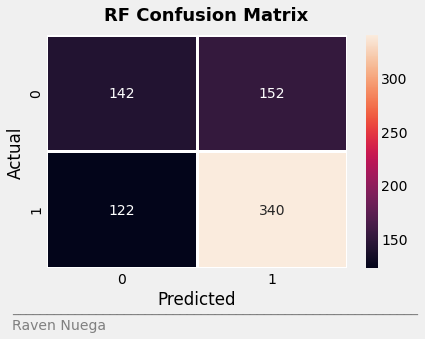

In [ ]:
confusion_matrix(y_rf, 'rf')


In [ ]:
svc = SVC(C=1, kernel='rbf', gamma='auto', probability=True, random_state=18)
y_svc = scores(svc)

df_predictions['Prediction'] = y_svc 
df_predictions

Accuracy (cross validation score): 0.671 (+/- 0.019)
f1 (cross validation score): 0.764 (+/- 0.007)
recall (cross validation score): 0.874 (+/- 0.044)
precision (cross validation score): 0.680 (+/- 0.028)


,Home,Away,Result,Date,Prediction
2603,Portland Trail Blazers,Miami Heat,0,02/05/2019,1
739,Chicago Bulls,Houston Rockets,0,03/10/2017,0
216,Phoenix Suns,Philadelphia 76ers,1,12/23/2016,1
2297,Portland Trail Blazers,Dallas Mavericks,1,12/23/2018,1
1707,Dallas Mavericks,Oklahoma City Thunder,0,02/28/2018,1
...,...,...,...,...,...
869,Denver Nuggets,New Orleans Pelicans,0,03/26/2017,1
1057,Phoenix Suns,New Orleans Pelicans,0,11/24/2017,0
2364,Charlotte Hornets,Dallas Mavericks,0,01/02/2019,1
839,Washington Wizards,Atlanta Hawks,1,03/22/2017,1


findfont: Font family ['Rockwell'] not found. Falling back to DejaVu Sans.


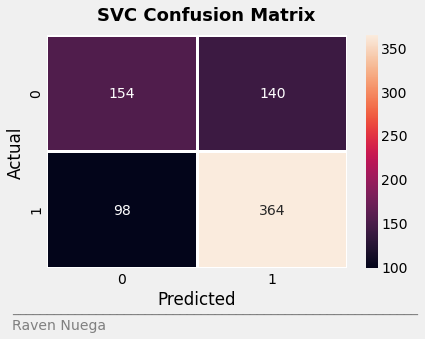

In [ ]:
confusion_matrix(y_svc, 'svc')

In [ ]:
dnn = MLPClassifier(activation='relu', solver='sgd', learning_rate='constant', learning_rate_init=0.001, alpha=0.0001, max_iter=500, random_state=18)
y_dnn = scores(dnn)

df_predictions['Prediction'] = y_dnn
df_predictions

Accuracy (cross validation score): 0.677 (+/- 0.013)
f1 (cross validation score): 0.756 (+/- 0.008)
recall (cross validation score): 0.816 (+/- 0.016)
precision (cross validation score): 0.703 (+/- 0.015)


,Home,Away,Result,Date,Prediction
2603,Portland Trail Blazers,Miami Heat,0,02/05/2019,1
739,Chicago Bulls,Houston Rockets,0,03/10/2017,0
216,Phoenix Suns,Philadelphia 76ers,1,12/23/2016,1
2297,Portland Trail Blazers,Dallas Mavericks,1,12/23/2018,1
1707,Dallas Mavericks,Oklahoma City Thunder,0,02/28/2018,0
...,...,...,...,...,...
869,Denver Nuggets,New Orleans Pelicans,0,03/26/2017,1
1057,Phoenix Suns,New Orleans Pelicans,0,11/24/2017,0
2364,Charlotte Hornets,Dallas Mavericks,0,01/02/2019,1
839,Washington Wizards,Atlanta Hawks,1,03/22/2017,1


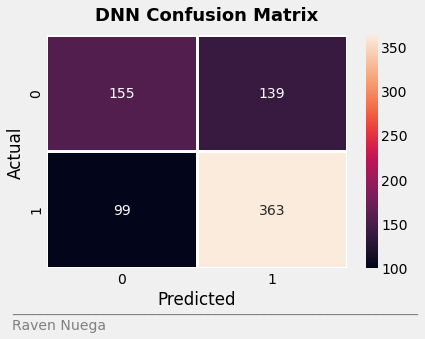

In [ ]:
confusion_matrix(y_dnn, 'dnn')